In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [21]:
#Visualizations

# Specify the path to your CSV file
file_path = "itineraries.csv"

# Convert the CSV file to a DataFrame
df = pd.read_csv(file_path)

# Display the first few rows of the DataFrame
print(df.head())


   searchDate  flightDate startingAirport destinationAirport  isBasicEconomy  \
0  2022-04-16  2022-04-17             ATL                BOS           False   
1  2022-04-16  2022-04-17             ATL                BOS           False   
2  2022-04-16  2022-04-17             ATL                BOS           False   
3  2022-04-16  2022-04-17             ATL                BOS           False   
4  2022-04-16  2022-04-17             ATL                BOS           False   

   isNonStop  baseFare  totalFare  
0       True    217.67      248.6  
1       True    217.67      248.6  
2       True    217.67      248.6  
3       True    217.67      248.6  
4       True    217.67      248.6  


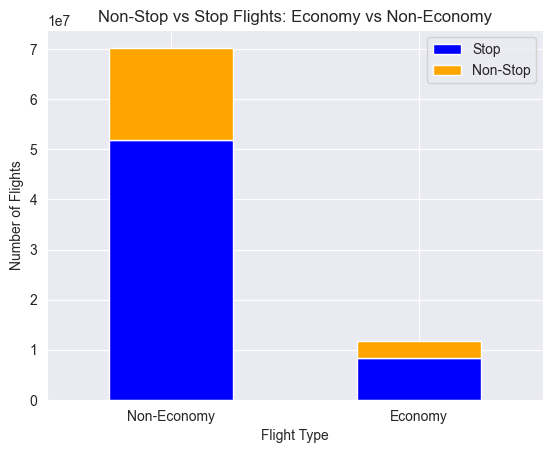

In [4]:
non_stop_counts = df.groupby(['isBasicEconomy', 'isNonStop']).size().unstack()

non_stop_counts.plot(kind='bar', stacked=True, color=['blue', 'orange'])
plt.title('Non-Stop vs Stop Flights: Economy vs Non-Economy')
plt.xticks(ticks=[0, 1], labels=['Non-Economy', 'Economy'], rotation=0)
plt.xlabel('Flight Type')
plt.ylabel('Number of Flights')
plt.legend(['Stop', 'Non-Stop'])
plt.show()


/var/folders/7q/7kvrhgd96yxftk3nv72_klcr0000gn/T/ipykernel_18276/1966411390.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='isBasicEconomy', y='totalFare', palette='coolwarm')


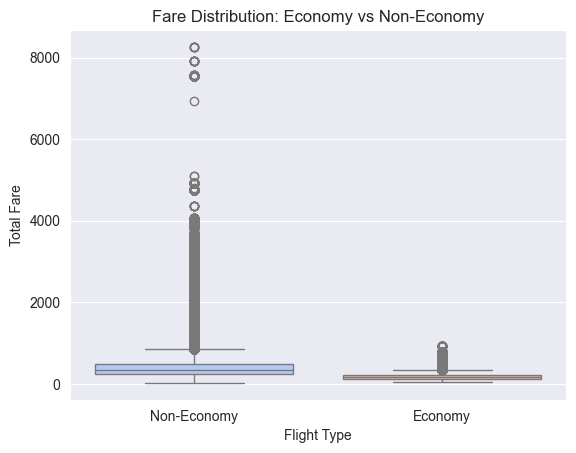

In [5]:
sns.boxplot(data=df, x='isBasicEconomy', y='totalFare', palette='coolwarm')
plt.xticks(ticks=[0, 1], labels=['Non-Economy', 'Economy'])
plt.title('Fare Distribution: Economy vs Non-Economy')
plt.xlabel('Flight Type')
plt.ylabel('Total Fare')
plt.show()

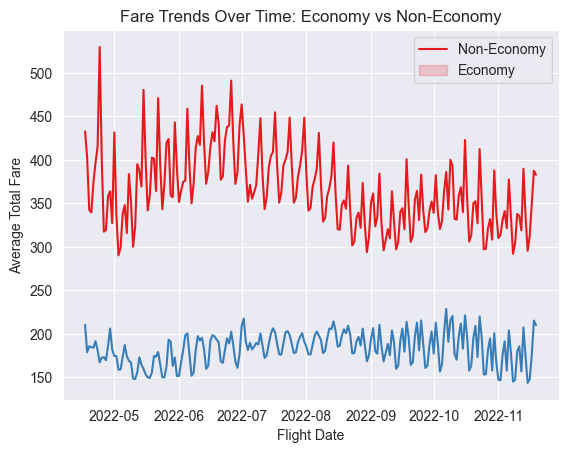

In [6]:
df['flightDate'] = pd.to_datetime(df['flightDate'])
avg_fare = df.groupby(['flightDate', 'isBasicEconomy'])['totalFare'].mean().reset_index()

sns.lineplot(data=avg_fare, x='flightDate', y='totalFare', hue='isBasicEconomy', palette='Set1')
plt.title('Fare Trends Over Time: Economy vs Non-Economy')
plt.xlabel('Flight Date')
plt.ylabel('Average Total Fare')
plt.legend(['Non-Economy', 'Economy'])
plt.show()


/var/folders/7q/7kvrhgd96yxftk3nv72_klcr0000gn/T/ipykernel_18276/1213232653.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=destination_counts.index, y=destination_counts.values, palette='viridis')


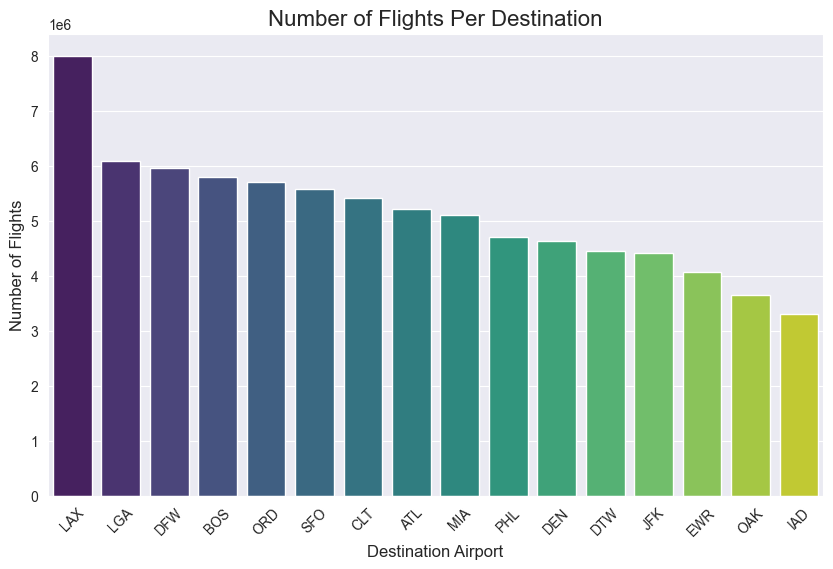

In [7]:
# Count the number of flights per destination
destination_counts = df['destinationAirport'].value_counts()

# Plot a bar chart
plt.figure(figsize=(10, 6))
sns.barplot(x=destination_counts.index, y=destination_counts.values, palette='viridis')
plt.title('Number of Flights Per Destination', fontsize=16)
plt.xlabel('Destination Airport', fontsize=12)
plt.ylabel('Number of Flights', fontsize=12)
plt.xticks(rotation=45)
plt.show()


In [25]:
df = pd.get_dummies(df, columns=["startingAirport", "destinationAirport", "isBasicEconomy", "isNonStop"])

dummy_columns = df.filter(like="startingAirport_").columns.union(
    df.filter(like="destinationAirport_").columns.union(
        df.filter(like="isBasicEconomy_").columns.union(
            df.filter(like="isNonStop_").columns
        )
    )
)

df[dummy_columns] = df[dummy_columns].astype(int)


In [26]:
df.head(5)

,searchDate,flightDate,baseFare,totalFare,startingAirport_ATL,startingAirport_BOS,startingAirport_CLT,startingAirport_DEN,startingAirport_DFW,startingAirport_DTW,...,destinationAirport_LGA,destinationAirport_MIA,destinationAirport_OAK,destinationAirport_ORD,destinationAirport_PHL,destinationAirport_SFO,isBasicEconomy_False,isBasicEconomy_True,isNonStop_False,isNonStop_True
0,2022-04-16,2022-04-17,217.67,248.6,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
1,2022-04-16,2022-04-17,217.67,248.6,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
2,2022-04-16,2022-04-17,217.67,248.6,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
3,2022-04-16,2022-04-17,217.67,248.6,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
4,2022-04-16,2022-04-17,217.67,248.6,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
